In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
# read Data for Prediction.csv into df
df = pd.read_csv('../data/data_for_prediction.csv')

In [4]:
def prepare_data(city_df, column_name, test_size, diff_order=1):
    """
    Prepare time series data for modeling.
    
    Args:
        city_df (pd.DataFrame): DataFrame containing time series data for a city.
        column_name (str): Name of the column to model.
        test_size (float): Proportion of data to use for testing.
        diff_order (int): Order of differencing (default is 1 for first-order differencing).
   
    Returns:
        tuple: A tuple containing training and testing datasets.
    """
    # Perform differencing
    city_df[column_name] = city_df[column_name].diff(diff_order)
    city_df.dropna(inplace=True)
    
    # Split data into training and testing sets
    train_size = int(len(city_df) * (1 - test_size))
    train_data, test_data = city_df[:train_size], city_df[train_size:]
    
    return train_data, test_data

In [5]:
def sarima_train_predict(train_data, seasonal_order, forecast_steps):
    """
    Apply an automated SARIMA (Seasonal Autoregressive Integrated Moving Average) model to time series data and make forecasts.

    Args:
        train_data (pd.Series): Time series training data.
        seasonal_order (tuple): Seasonal order for SARIMA (default is no seasonality).
        forecast_steps (int): Number of steps to forecast into the future. (default is 12 months)

    Returns:
        pd.Series: A Series containing the forecasted values with confidence intervals.
    """

    # Automatically select SARIMA model using pmdarima
    model = pm.auto_arima(train_data, seasonal=True, m=12, stepwise=True,
                            suppress_warnings=True, error_action="ignore")

    # Extract seasonal order (P, D, Q, s) from the model
    P, D, Q, s = model.seasonal_order

    # Extract non-seasonal order (p, d, q) from the model
    p, d, q = model.order

    # Print
    print('Seasonal Order:', seasonal_order)
    print('Order:', (p, d, q))
    
    # Create a SARIMA model (SARIMAX is a more generalized class) 
    sarima_model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s))
    
    # Fit the SARIMA model to the training data
    sarima_results = sarima_model.fit(disp=False)
    
    # Make forecasts
    forecast_series = sarima_results.get_forecast(steps=forecast_steps).summary_frame()
    
    #print(forecast_series)

    return forecast_series

In [6]:
from tqdm import tqdm

# Convert 'period_end' column to datetime
df['period_end'] = pd.to_datetime(df['period_end'])
# List of unique cities or regions in your dataset
cities = df['city'].unique()
# Create an empty DataFrame to store the predictions
predictions_df = pd.DataFrame(columns=['City', 'Date', 'Predicted_Value', 'Lower_CI', 'Upper_CI'])

# Iterate over cities
for city in tqdm(cities):

    city_df = df[df['city'] == city].copy()
    
    column_name = 'median_sale_price'  # Adjust this to the column you want to predict
    
    train_data, test_data = prepare_data(city_df, 'median_sale_price', test_size=0, diff_order=1) # 2.order difference can be tested. 1. order is enough for most cases.
    
    train_data.reset_index(drop=True, inplace=True)
    
    #print(test_data.shape, "test data shape")
    
    last_date = train_data['period_end'].max()
    
    train_data = train_data[column_name]

    print(city, "is training")
    
    if test_data.shape[0] > 0:
        forecast_steps = test_data.shape[0]
    else:
        forecast_steps = 12
    
    # Use sarima_train_predict function.
    forecast_series = sarima_train_predict(train_data, seasonal_order=(1, 1, 1, 12), forecast_steps = forecast_steps)
    
    # Calculate confidence intervals
    forecast_mean = forecast_series['mean']
    forecast_ci = forecast_series[['mean_ci_lower', 'mean_ci_upper']]

    # Generate proper date range for predictions
    
    predicted_date_range = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')
   
    # Create a DataFrame for predictions
    city_predictions = pd.DataFrame({
        'City': [city] * forecast_steps,
        'Date': predicted_date_range,
        'Predicted_Value': forecast_mean.values,
        'Lower_CI': forecast_ci['mean_ci_lower'].values,
        'Upper_CI': forecast_ci['mean_ci_upper'].values
    })

    # Append predictions to the main predictions DataFrame
    # predictions_df = predictions_df.append(city_predictions, ignore_index=True)
    predictions_df = pd.concat([predictions_df, city_predictions], ignore_index=True)


  0%|          | 0/8 [00:00<?, ?it/s]

Austin is training


C:\Users\monac\AppData\Local\Temp\ipykernel_20032\3486286366.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predictions_df = pd.concat([predictions_df, city_predictions], ignore_index=True)
 12%|█▎        | 1/8 [00:07<00:55,  7.98s/it]

Seasonal Order: (1, 1, 1, 12)
Order: (1, 0, 0)
Boston is training
Seasonal Order: (1, 1, 1, 12)
Order: (4, 0, 2)


c:\Users\monac\Documents\virtual-environments\harrington-associates\upwork\python-data-science-projects\scott\real-estate-predictions\my_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\monac\Documents\virtual-environments\harrington-associates\upwork\python-data-science-projects\scott\real-estate-predictions\my_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 25%|██▌       | 2/8 [00:48<02:41, 26.84s/it]

Chicago is training
Seasonal Order: (1, 1, 1, 12)
Order: (1, 0, 0)


 38%|███▊      | 3/8 [00:59<01:39, 19.88s/it]

Denver is training


 50%|█████     | 4/8 [01:07<00:59, 14.95s/it]

Seasonal Order: (1, 1, 1, 12)
Order: (0, 0, 1)
Miami is training


 62%|██████▎   | 5/8 [01:08<00:29,  9.97s/it]

Seasonal Order: (1, 1, 1, 12)
Order: (0, 0, 0)
New York is training
Seasonal Order: (1, 1, 1, 12)
Order: (1, 0, 1)


c:\Users\monac\Documents\virtual-environments\harrington-associates\upwork\python-data-science-projects\scott\real-estate-predictions\my_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 75%|███████▌  | 6/8 [01:21<00:21, 10.99s/it]

San Francisco is training


 88%|████████▊ | 7/8 [02:16<00:25, 25.35s/it]

Seasonal Order: (1, 1, 1, 12)
Order: (0, 0, 0)
Average of 7 City is training
Seasonal Order: (1, 1, 1, 12)
Order: (2, 0, 3)


c:\Users\monac\Documents\virtual-environments\harrington-associates\upwork\python-data-science-projects\scott\real-estate-predictions\my_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\monac\Documents\virtual-environments\harrington-associates\upwork\python-data-science-projects\scott\real-estate-predictions\my_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\monac\Documents\virtual-environments\harrington-associates\upwork\python-data-science-projects\scott\real-estate-predictions\my_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  w

In [7]:
predictions_df['Date'].min()

Timestamp('2023-12-31 00:00:00')

In [8]:
def convert_to_original_scale(city_predictions, main_data):
    # Create a DataFrame to store the converted predictions
    converted_predictions = pd.DataFrame(columns=['City', 'Date', 'Predicted_Value', 'Lower_CI', 'Upper_CI'])
    
    for city in city_predictions['City'].unique():
                
        city_data = main_data[main_data['city'] == city]
        
        first_predicted_date = predictions_df['Date'].loc[0]
        last_date_before_prediction = first_predicted_date - pd.DateOffset(months=1)
        
        last_date_before_prediction = city_data[(city_data['period_end'].dt.year == last_date_before_prediction.year) & (city_data['period_end'].dt.month == last_date_before_prediction.month)]['period_end'].iloc[0]
        last_value_before_prediction = city_data[(city_data['period_end'].dt.year == last_date_before_prediction.year) & (city_data['period_end'].dt.month == last_date_before_prediction.month)]['median_sale_price'].iloc[0]

        city_predictions_city = city_predictions[city_predictions['City'] == city].copy()
        
        # Inverse differencing for Predicted_Value
        city_predictions_city['Predicted_Value'] = city_predictions_city['Predicted_Value'].cumsum() + last_value_before_prediction
        
        # Inverse differencing for Lower_CI
        city_predictions_city['Lower_CI'] = city_predictions_city['Lower_CI'].cumsum() + last_value_before_prediction
        
        # Inverse differencing for Upper_CI
        city_predictions_city['Upper_CI'] = city_predictions_city['Upper_CI'].cumsum() + last_value_before_prediction
        
        converted_predictions = pd.concat([converted_predictions, city_predictions_city], ignore_index=True)
    
    return converted_predictions

# Usage example:
converted_predictions = convert_to_original_scale(predictions_df, df)

C:\Users\monac\AppData\Local\Temp\ipykernel_20032\162009555.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  converted_predictions = pd.concat([converted_predictions, city_predictions_city], ignore_index=True)


City
Austin               Axes(0.125,0.11;0.775x0.77)
Average of 7 City    Axes(0.125,0.11;0.775x0.77)
Boston               Axes(0.125,0.11;0.775x0.77)
Chicago              Axes(0.125,0.11;0.775x0.77)
Denver               Axes(0.125,0.11;0.775x0.77)
Miami                Axes(0.125,0.11;0.775x0.77)
New York             Axes(0.125,0.11;0.775x0.77)
San Francisco        Axes(0.125,0.11;0.775x0.77)
Name: Predicted_Value, dtype: object

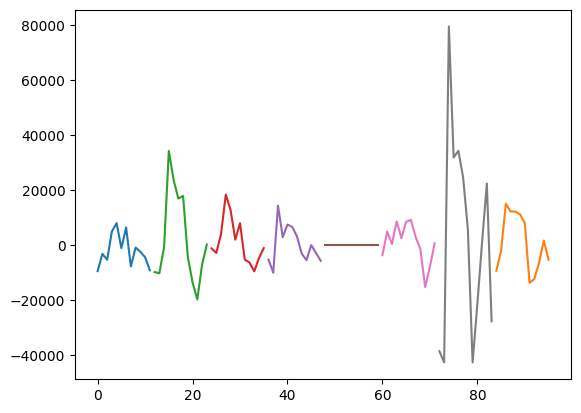

In [9]:
predictions_df.groupby('City')['Predicted_Value'].plot()

City
Austin               Axes(0.125,0.11;0.775x0.77)
Average of 7 City    Axes(0.125,0.11;0.775x0.77)
Boston               Axes(0.125,0.11;0.775x0.77)
Chicago              Axes(0.125,0.11;0.775x0.77)
Denver               Axes(0.125,0.11;0.775x0.77)
Miami                Axes(0.125,0.11;0.775x0.77)
New York             Axes(0.125,0.11;0.775x0.77)
San Francisco        Axes(0.125,0.11;0.775x0.77)
Name: Predicted_Value, dtype: object

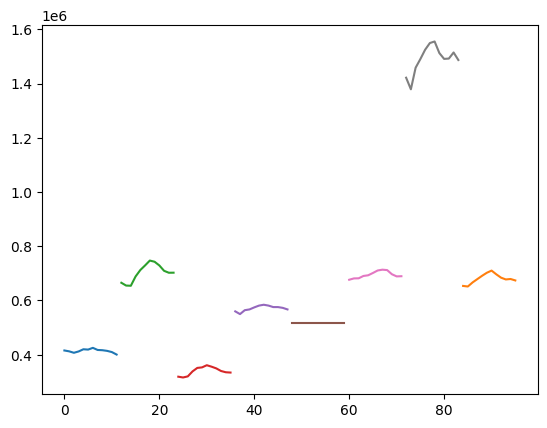

In [10]:
# Pandas e notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)
converted_predictions.groupby('City')['Predicted_Value'].plot()

In [11]:
import os 
def create_directory_if_not_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [12]:
from matplotlib.ticker import ScalarFormatter

def plot_actual_vs_predicted_and_save(df, predictions_df, city_name, column_name, save_path=None):
    # Filter data for the specified city and column
    city_data = df[(df['city'] == city_name) & (df['property_type'] == 'All Residential')]
    
    # Extract actual values and dates
    actual_values = city_data[column_name]
    actual_dates = city_data['period_end']
    
    # Extract predicted values, lower and upper confidence intervals, and dates
    predictions = predictions_df[(predictions_df['City'] == city_name)]['Predicted_Value']
    lower_ci = predictions_df[(predictions_df['City'] == city_name)]['Lower_CI']
    upper_ci = predictions_df[(predictions_df['City'] == city_name)]['Upper_CI']
    prediction_dates = predictions_df[(predictions_df['City'] == city_name)]['Date']
    
    # Plot the data
    plt.figure(figsize=(15, 7))
    plt.plot(actual_dates, actual_values, label='Actual', marker='o', linestyle='-')
    plt.plot(prediction_dates, predictions, label='Predicted', marker='o', linestyle='-', color='orange')
    plt.fill_between(prediction_dates, lower_ci, upper_ci, color='k', alpha=0.1)
    plt.title(f'{city_name} - Median Sale Prediction')
    plt.xlabel('Year')
    plt.ylabel(column_name)
    
    # Customize the y-axis labels to disable scientific notation
    plt.gca().get_yaxis().set_major_formatter(ScalarFormatter(useMathText=False))
    
    # Customize the grid to make it softer
    plt.grid(alpha=0.5)
    
    plt.legend()
    
    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()

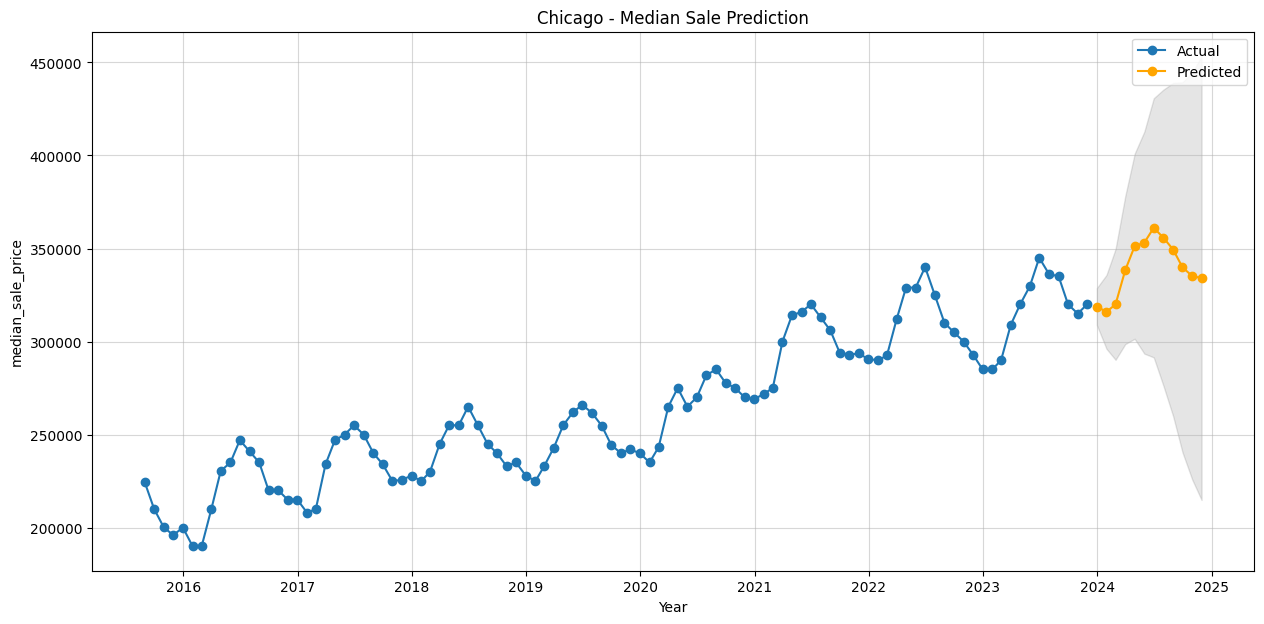

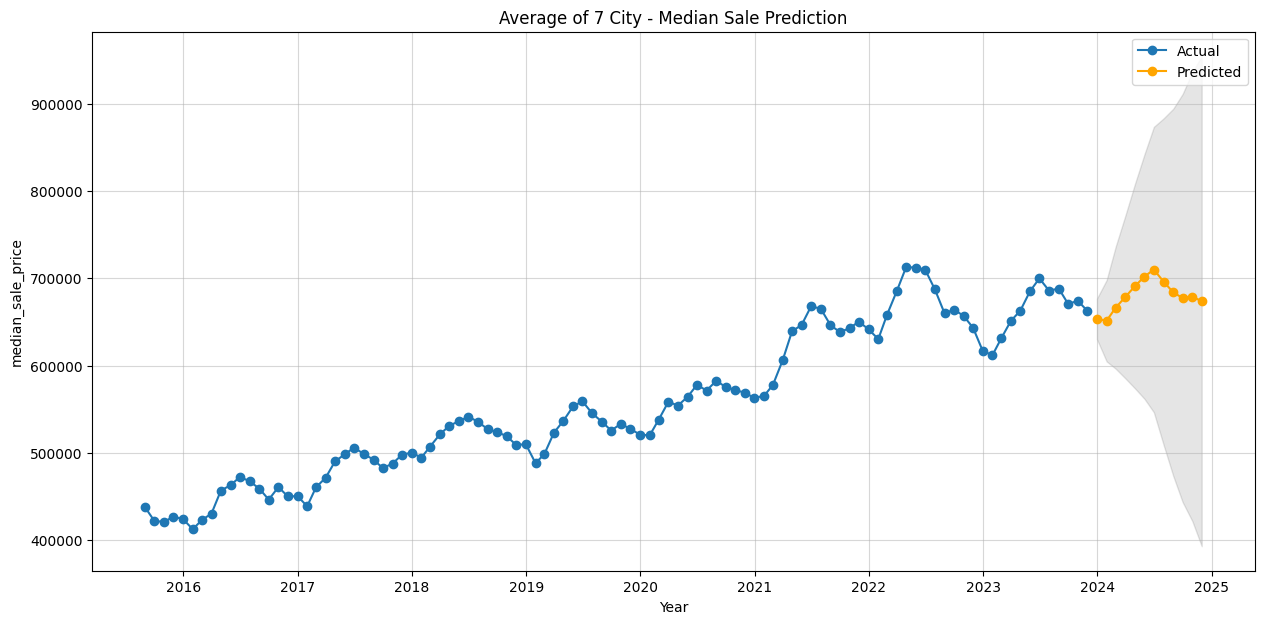

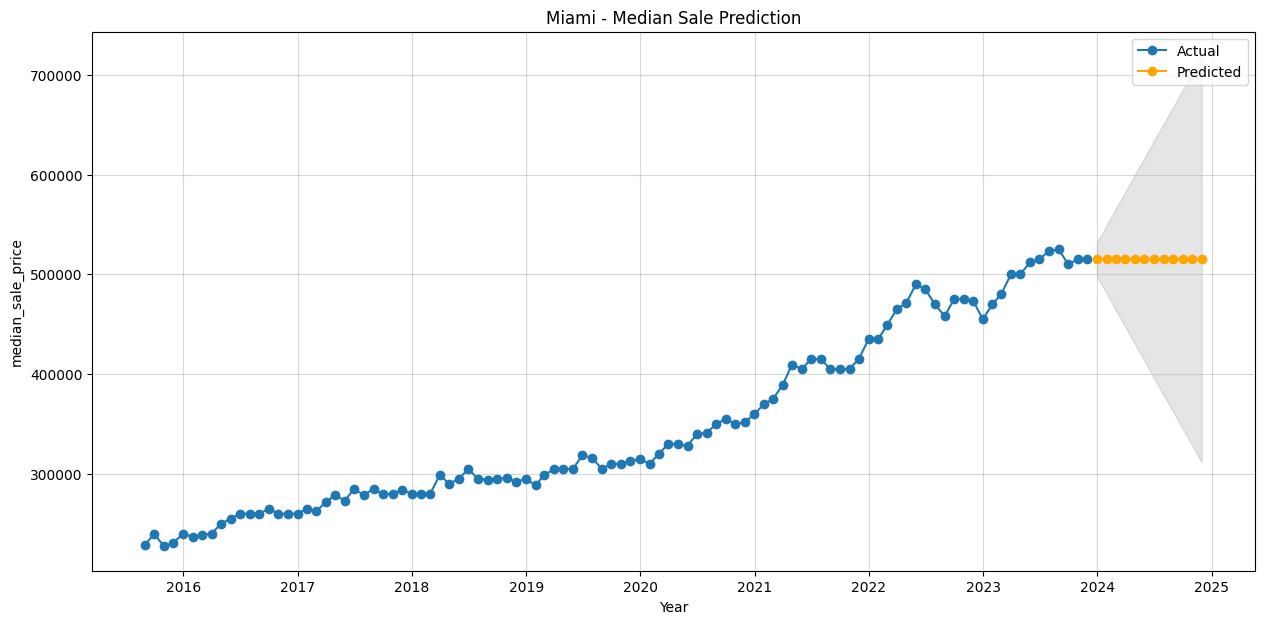

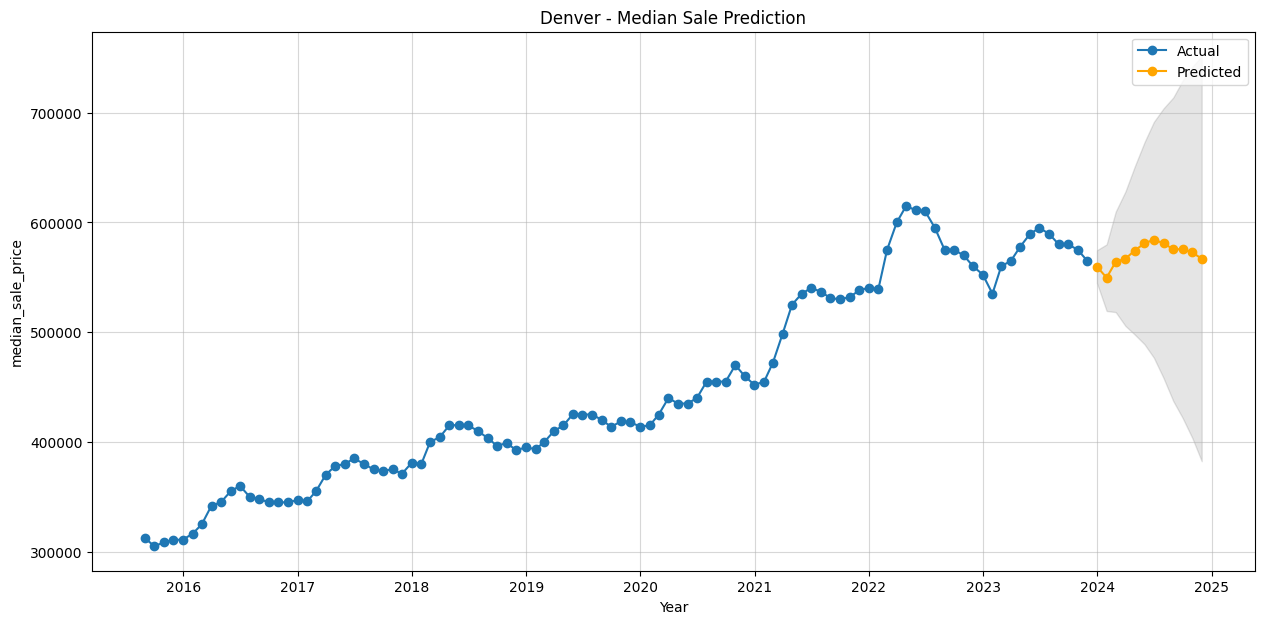

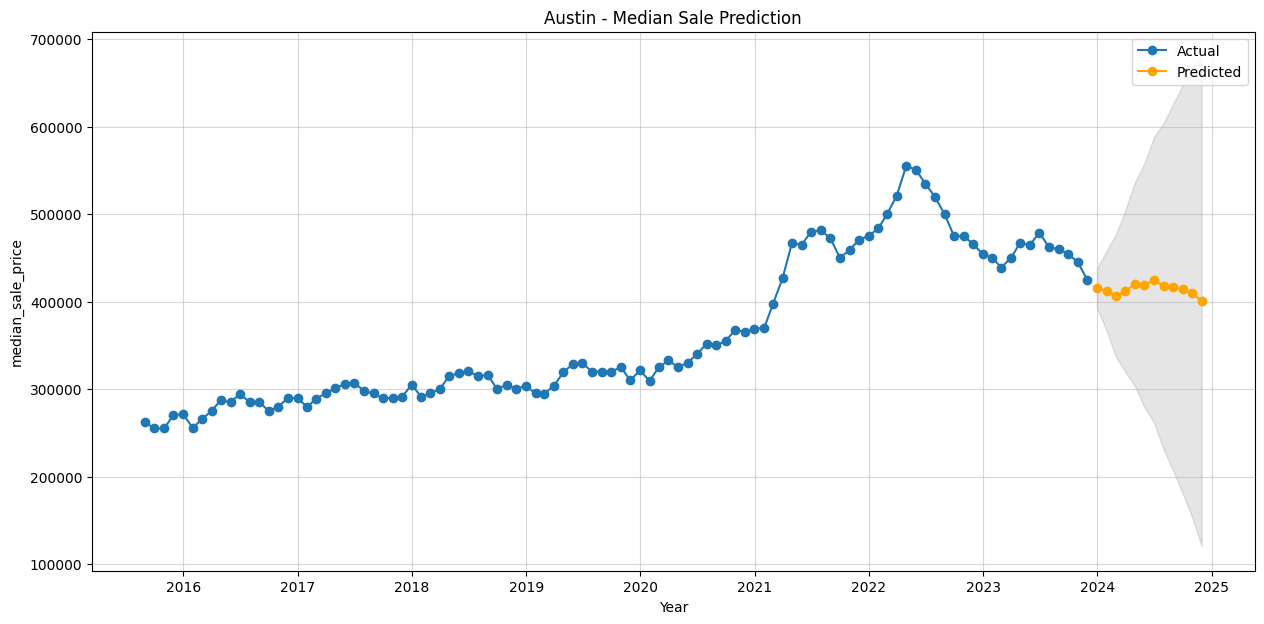

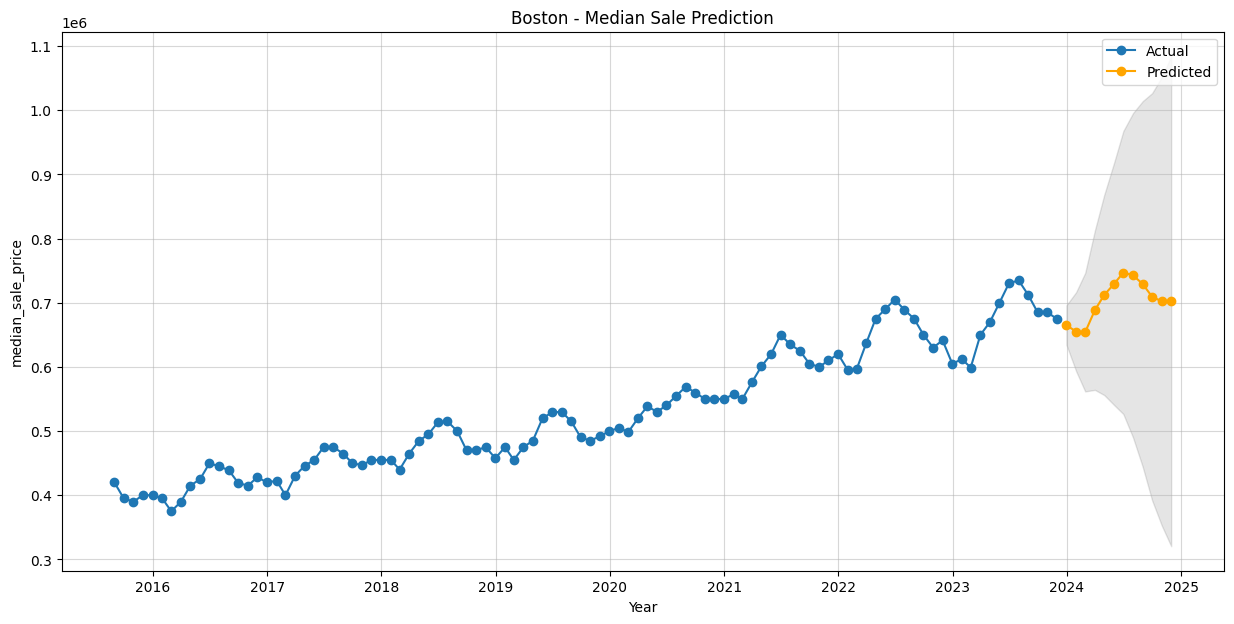

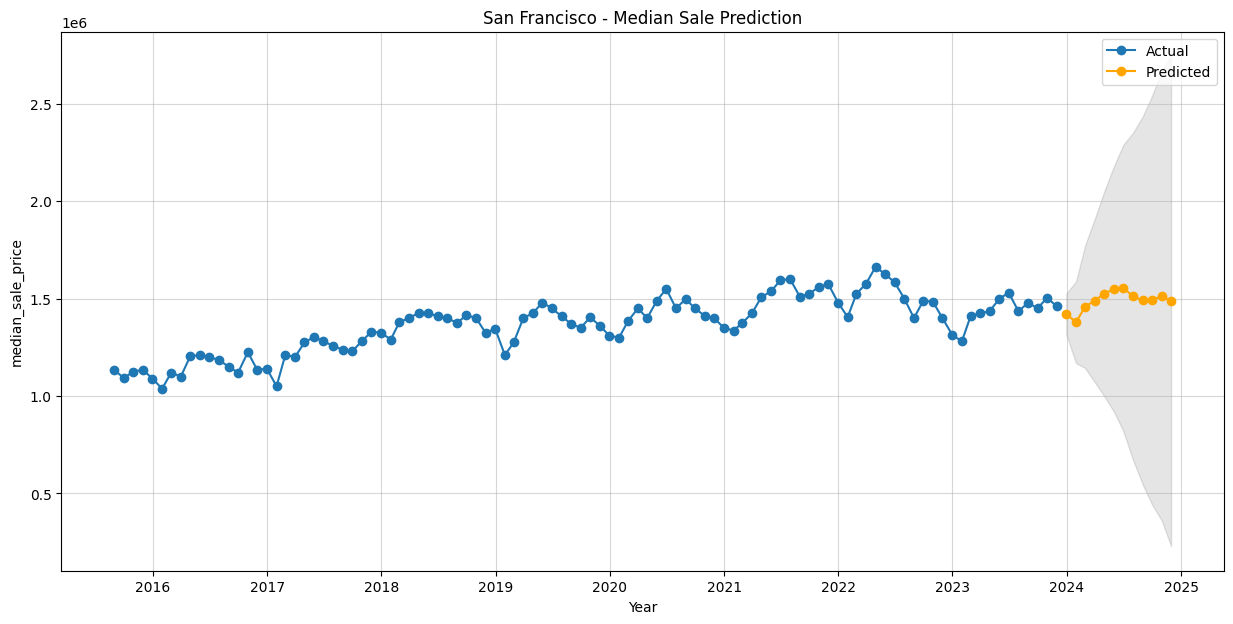

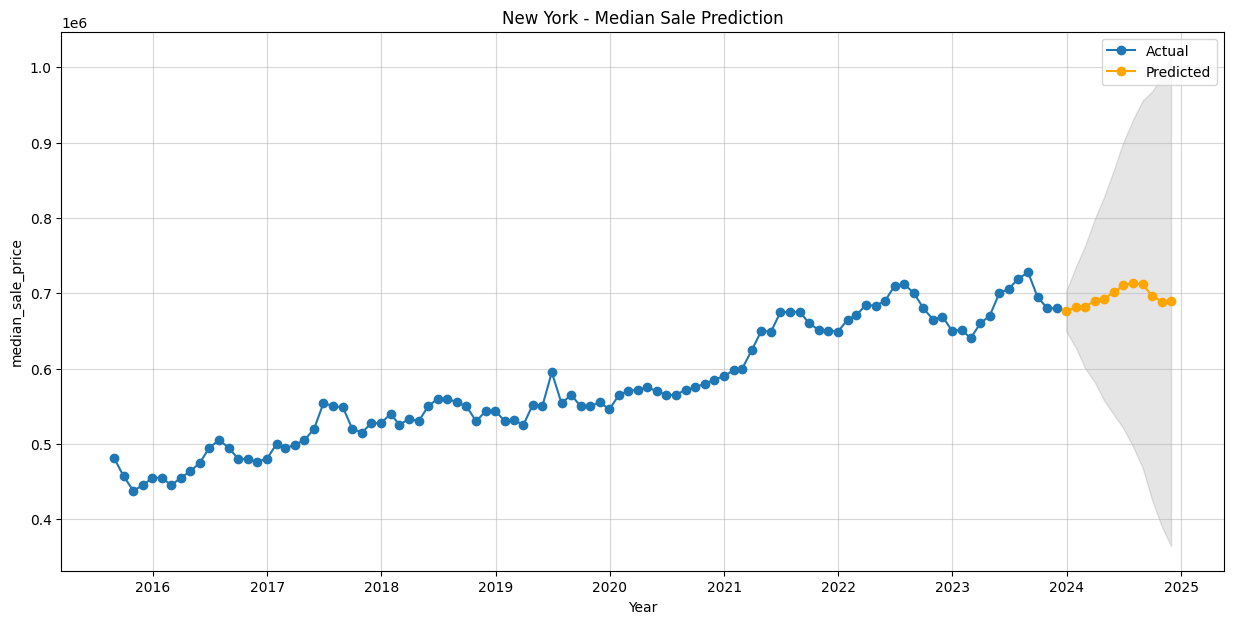

In [13]:
# Example usage:
x = ['Chicago', 'Average of 7 City', 'Miami', 'Denver', 'Austin', "Boston", "San Francisco", "New York"]
column_name = 'median_sale_price'

output_folder = '../city-predictions'  # Define the folder where plots will be saved
create_directory_if_not_exists(output_folder)  # Create the folder if it doesn't exist

for city_name in x:
    save_path = os.path.join(output_folder, f"{city_name}_prediction_plot.png")
    plot_actual_vs_predicted_and_save(df, converted_predictions, city_name, column_name, save_path)

In [14]:
def compute_roi(df,converted_predictions):
    last_price_city =  df.groupby('city').last()['median_sale_price'].to_frame().reset_index()
    last_price_predicted = converted_predictions.groupby('City').last()['Predicted_Value'].to_frame().reset_index()

    last_price_city = last_price_city.sort_values('city')
    last_price_predicted = last_price_predicted.sort_values('City')

    # rename  last_price_predicted City as city
    last_price_predicted = last_price_predicted.rename(columns={'City':'city'})

    # merge on city
    last_price = pd.merge(last_price_city, last_price_predicted, on='city', how='inner')

    last_price['ROI'] = ((last_price['Predicted_Value'] - last_price['median_sale_price']) / last_price['median_sale_price']) * 100
    
    return last_price

In [15]:
def visualize_positive_roi(last_price):
    # Sort the data by ROI in ascending order
    last_price_city_positive_roi = last_price[last_price['ROI'] >= 0]
    sorted_data = last_price_city_positive_roi.sort_values(by='ROI', ascending=False)

    # Create a horizontal bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(sorted_data['city'], sorted_data['ROI'], color='lightblue', edgecolor='lightblue')  # Set edgecolor to match the bar color
    plt.xlabel('ROI (%)', fontsize=14)  # Increase label font size
    plt.ylabel('City', fontsize=14)  # Increase label font size
    plt.title('ROI for Each City (Positive ROI Only)', fontsize=16, pad=20)  # Increase title font size and add padding
    plt.tick_params(axis='y', labelsize=12)  # Increase y-axis tick label font size
    plt.tight_layout()

    # Add ROI values closer to the bars
    # Add ROI values closer to the bars
    for bar, roi in zip(bars, sorted_data['ROI']):
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2, f'{roi:.2f}%', va='center', ha='left', fontsize = 16)  # Adjust distance from bars and add a white box

    # Remove grid lines and frame
    plt.grid(False)
    plt.box(False)  # Remove rectangular frame
    # Remove rectangular frame

    return plt

def visualize_positive_roi(last_price):
    # Sort the data by ROI in ascending order
    last_price_city_positive_roi = last_price[last_price['ROI'] >= 0]
    sorted_data = last_price_city_positive_roi.sort_values(by='ROI', ascending=False)

    # Create a horizontal bar plot
    plt.figure(figsize=(16, 8))
    bars = plt.barh(sorted_data['city'], sorted_data['ROI'], color='lightblue', edgecolor='lightblue')  # Set edgecolor to match the bar color
    plt.xlabel('ROI (%)', fontsize=14)  # Increase label font size
    plt.ylabel('City', fontsize=14)  # Increase label font size
    plt.title('ROI for Each City (Positive ROI Only)', fontsize=20, pad=20)  # Increase title font size and add padding
    plt.tick_params(axis='y', labelsize=12)  # Increase y-axis tick label font size
    plt.tight_layout()

    # Add ROI values closer to the bars
    for bar, roi in zip(bars, sorted_data['ROI']):
        plt.text(bar.get_width() + 0, bar.get_y()  + bar.get_height() / 2, f'{roi:.2f}%', va='center', ha='left', fontsize=20)  # Adjust distance from bars and add a white box
        
    # Remove grid lines and frame
    plt.grid(False)
    plt.box(False)  # Remove rectangular frame
    plt.style.use('ggplot')
    return plt

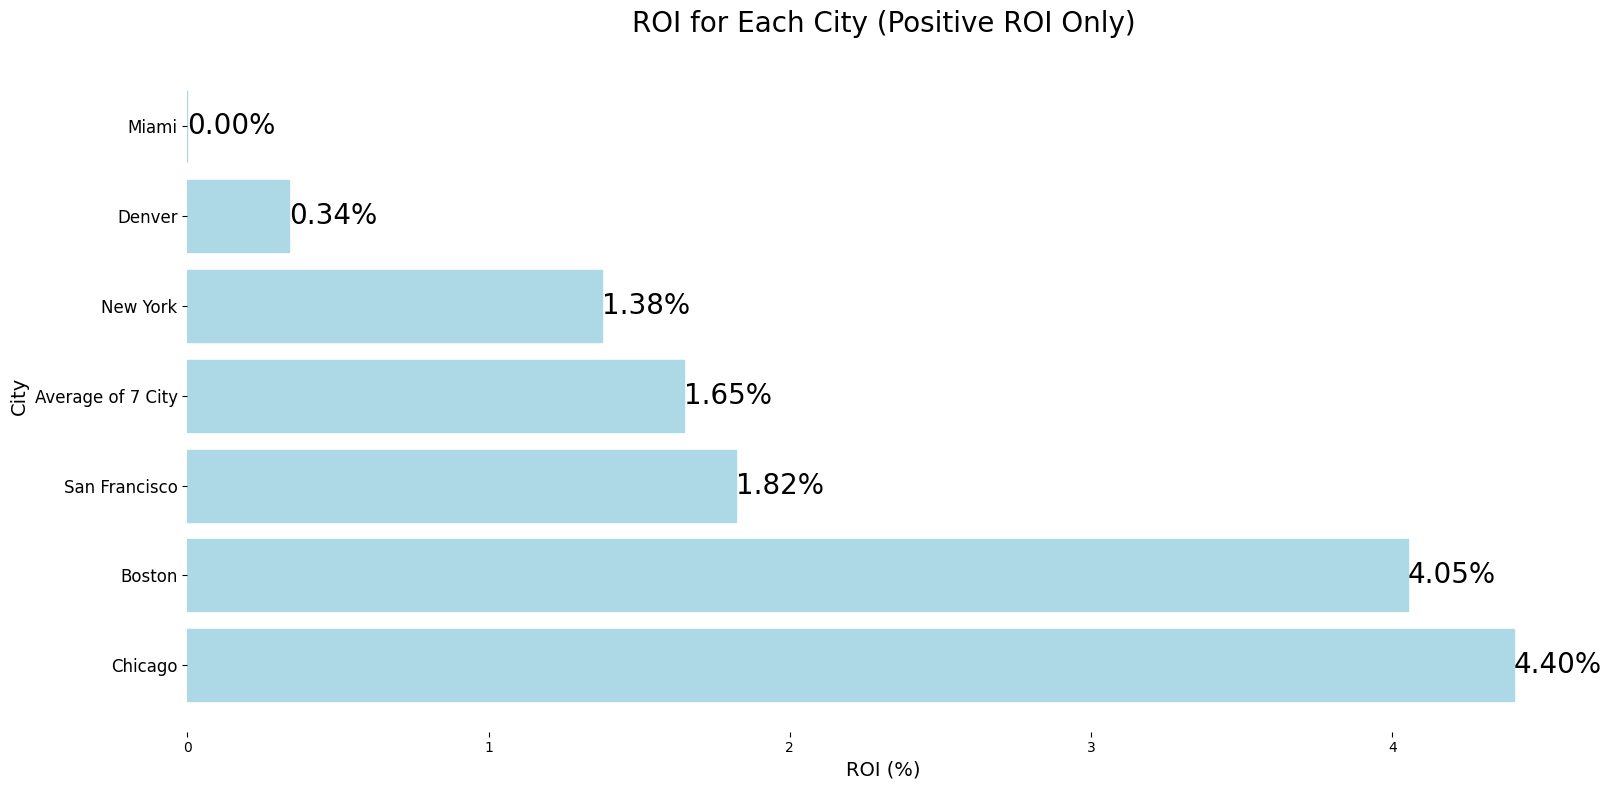

In [16]:
last_price = compute_roi(df,converted_predictions) 

visualize_positive_roi(last_price).savefig("../city-predictions/roi.png")

In [17]:
def visualize_negative_roi(last_price):
    # Sort the data by ROI in ascending order
    last_price_city_negative_roi = last_price[last_price['ROI'] < 0]
    sorted_data = last_price_city_negative_roi.sort_values(by='ROI', ascending=True)

    # Create a vertical bar plot with smaller bars
    plt.figure(figsize=(10, 6))
    bars = plt.bar(sorted_data['city'], sorted_data['ROI'], color='lightcoral', edgecolor='lightcoral', width=0.5)  # Adjust the width parameter
    plt.ylabel('ROI (%)', fontsize=14)  # Increase label font size
    plt.xlabel('City', fontsize=14)  # Increase label font size
    plt.title('ROI for Each City (Negative ROI Only)', fontsize=16, pad=20)  # Increase title font size and add padding
    plt.xticks(rotation=45, fontsize=12)  # Increase x-axis tick label font size and rotate labels for readability
    plt.tight_layout()

    
    for bar, roi in zip(bars, sorted_data['ROI']):
        plt.text(bar.get_x() + bar.get_width() / 2, max(bar.get_height() + 1, 0.05), f'{roi:.2f}%', ha='center', fontsize=16)  # Adjust distance from bars

    # Remove grid lines and frame
    plt.grid(False)
    plt.box(False)  # Remove rectangular frame

    return plt

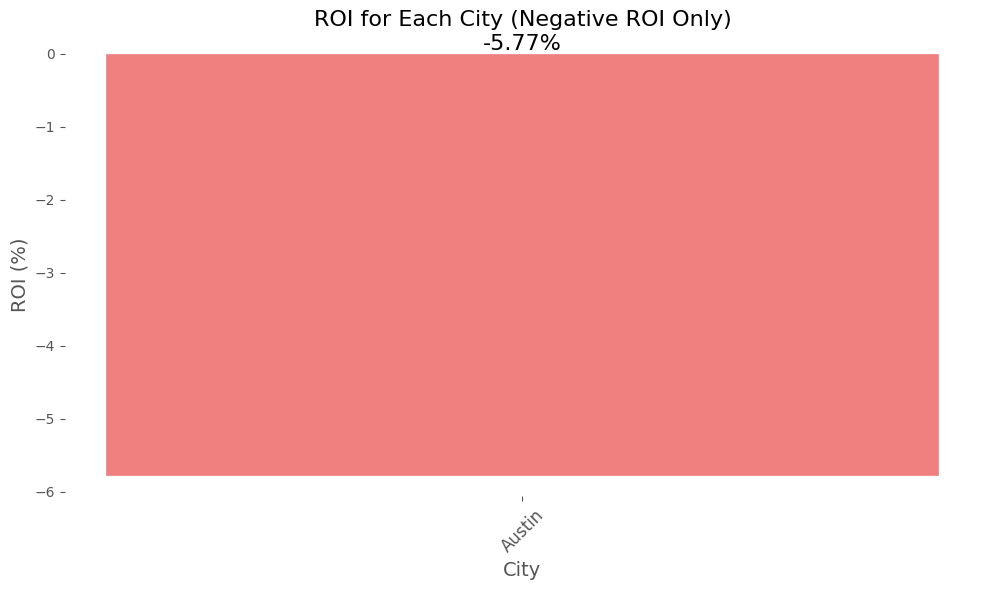

In [18]:
visualize_negative_roi(last_price).savefig("../city-predictions/negative_roi.png")